# Time Series Classification and Clustering Assignment

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

### Import the Walmart stock price data set (WMT_data.csv).

In [0]:
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%205/WMT_data.csv')

In [8]:
df.head(2)

,date,open,high,low,close,volume,Name
0,2013-02-08,71.20,71.64,71.07,71.48,5906823,WMT
1,2013-02-11,71.25,71.51,70.53,71.40,6202534,WMT


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
date      1259 non-null object
open      1259 non-null float64
high      1259 non-null float64
low       1259 non-null float64
close     1259 non-null float64
volume    1259 non-null int64
Name      1259 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 69.0+ KB


In [0]:
# df['date'] = pd.to_datetime(df['date'])

### Transform the data to be able to predict minor direction changes in the stock's price, given 180 days of history.

- Remember to calculate daily returns from the observed values (closing price).
- Make the critera for identifying a direction change when the observed values (closing price) cross the 5 day moving average.
- Create a binary column that defaults to 0 unless the criteria is met (then updates to 1).
- Shift the data set so that you have 180 days of history for each record.

In [0]:
df['returns'] = df['close'].pct_change()
df['ma_5'] = df['close'].rolling(5).mean()

df['cross'] = 'None'
df.loc[(df['close'] < df['ma_5']),'cross'] = 'Negative'
df.loc[(df['close'] > df['ma_5']),'cross'] = 'Positive'
df['change'] = df['cross'].eq(df['cross'].shift())

df['binary'] = 0
df.loc[(df['change']==True) & (df['cross']!='None'), 'binary']=1

In [11]:
df.head(10)

,date,open,high,low,close,volume,Name,returns,ma_5,cross,change,binary
0,2013-02-08,71.20,71.64,71.070,71.48,5906823,WMT,NaN,NaN,None,False,0
1,2013-02-11,71.25,71.51,70.530,71.40,6202534,WMT,-0.001119,NaN,None,True,0
2,2013-02-12,71.49,71.66,71.100,71.40,4761910,WMT,0.000000,NaN,None,True,0
3,2013-02-13,71.29,71.70,71.210,71.39,3969807,WMT,-0.000140,NaN,None,True,0
4,2013-02-14,71.10,71.23,70.755,70.82,6820952,WMT,-0.007984,71.298,Negative,False,0
5,2013-02-15,69.54,70.00,68.130,69.30,25687156,WMT,-0.021463,70.862,Negative,True,1
6,2013-02-19,69.19,69.45,68.540,68.76,14683322,WMT,-0.007792,70.334,Negative,True,1
7,2013-02-20,68.72,69.85,68.300,69.21,11973720,WMT,0.006545,69.896,Negative,True,1
8,2013-02-21,70.00,71.47,69.720,70.26,20425983,WMT,0.015171,69.670,Positive,False,0
9,2013-02-22,70.22,70.54,69.890,70.40,9169060,WMT,0.001993,69.586,Positive,True,1


In [0]:
df.dropna(inplace=True)


In [0]:
transformed = df[['date','returns','binary']]
history = 180
future = 0
shifts = [x + future for x in list(range(1,history+1))]
for shift in shifts:
    transformed['t-'+ str(shift)]= transformed['returns'].shift(shift)
transformed.dropna(inplace=True)

In [0]:
transformed.head()

,date,returns,binary,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12,t-13,t-14,t-15,t-16,t-17,t-18,t-19,t-20,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30,t-31,t-32,t-33,t-34,t-35,t-36,t-37,...,t-141,t-142,t-143,t-144,t-145,t-146,t-147,t-148,t-149,t-150,t-151,t-152,t-153,t-154,t-155,t-156,t-157,t-158,t-159,t-160,t-161,t-162,t-163,t-164,t-165,t-166,t-167,t-168,t-169,t-170,t-171,t-172,t-173,t-174,t-175,t-176,t-177,t-178,t-179,t-180
185,2013-11-01,0.004169,0,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,0.001217,...,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
186,2013-11-04,0.003374,1,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,-0.001891,...,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
187,2013-11-05,0.001164,1,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,0.006088,...,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
188,2013-11-06,0.009558,1,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,0.005648,...,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.000669,0.000134,-0.001069,0.007674,0.015725,0.001918,0.007453,0.002768,-0.003448,-0.009833,-0.005838,0.000679,0.008495,-0.000685,-0.003955,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171
189,2013-11-07,-0.008316,1,0.009558,0.001164,0.003374,0.004169,-0.002080,-0.001947,-0.001037,0.013933,-0.004449,0.006851,-0.005503,0.015569,-0.007397,-0.000924,0.002381,0.016539,-0.004151,-0.001871,0.000401,0.024521,0.001372,0.014331,-0.012775,-0.004921,-0.007596,0.001767,-0.005003,-0.005379,-0.003484,-0.000402,-0.014521,-0.008767,0.007781,-0.004986,-0.002748,0.016900,0.004948,...,0.014645,-0.017195,-0.002161,0.002676,-0.001146,0.009898,0.005428,-0.009601,0.010739,0.011782,0.002493,0.002632,-0.000263,0.007822,0.008018,0.00066

### Train a Logistic Regression classification model on the transformed data.

In [0]:
X = transformed.drop(['date','returns','binary'], axis=1)
y = transformed['binary']

In [15]:
X.shape,y.shape

((1075, 180), (1075,))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
model = LogisticRegression(class_weight='balanced')
model = model.fit(X_train,y_train)
predictions = model.predict(X_test)

### Run a classification report and evaluate the performance of the classifier.

In [17]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.32      0.39      0.36        94
           1       0.73      0.66      0.69       229

    accuracy                           0.59       323
   macro avg       0.53      0.53      0.52       323
weighted avg       0.61      0.59      0.60       323



### Transform the data again to have 10 days of history for clustering.

In [0]:
transformed = df[['date','returns','binary']]
history = 10
future = 0
shifts = [x + future for x in list(range(1,history+1))]
for shift in shifts:
    transformed['t-'+ str(shift)]= transformed['returns'].shift(shift)
transformed.dropna(inplace=True)
X = transformed.drop(['date','returns','binary'], axis=1)

### Train a K Means clustering model on the data. 

Try different values for K and see how the summary changes.

In [0]:
def kmeans (df,clusters=2):
    model = KMeans(n_clusters=clusters,random_state=25)
    clusters = model.fit_predict(df)
    results = df.copy()
    results['cluster'] = clusters

    cluster_size = results.groupby(['cluster']).size().reset_index()
    cluster_size.columns =['cluster','counts']
    cluster_means = results.groupby(['cluster'], as_index=False).mean()
    summary = pd.merge(cluster_size,cluster_means,on='cluster')

    return results,summary

results,summmary = kmeans(X,clusters=8)

In [0]:
model = KMeans(n_clusters=2,random_state=25)
clusters = model.fit_predict(X)
results = X.copy()
results['cluster'] = clusters

In [21]:
summmary

,cluster,counts,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0,183,-0.001495,0.006089,0.006814,0.004069,0.001035,0.002013,-0.001944,-0.001942,0.002087,0.009986
1,1,184,-0.000758,0.002777,-0.012181,0.001190,0.001638,0.001873,-0.000402,-0.004815,-0.000026,0.002258
2,2,160,0.008102,-0.002127,0.001190,0.008217,-0.010814,-0.001070,0.002601,0.002044,0.000260,-0.001701
3,3,149,0.001063,-0.000661,0.002123,0.001186,0.005388,0.004280,-0.000183,-0.002200,0.009056,-0.011158
4,4,172,0.001914,0.000605,0.000133,0.000797,0.006037,-0.008863,-0.001542,0.010956,0.000277,0.000911
5,5,125,-0.012342,-0.011350,0.003796,-0.001393,-0.000373,-0.000772,0.001126,0.000503,0.001885,0.002307
6,6,167,0.001384,0.003183,0.001500,-0.002758,0.001983,0.001824,0.010385,-0.000631,-0.009609,-0.002340
7,7,105,0.003398,0.000120,0.001973,-0.014092,-0.003775,0.006212,-0.009812,-0.000760,0.000337,0.000987


### Visualize the summary of the clustering results as a heatmap.

In [0]:
# heatmap

def heatmap(df, length=8, width=18, title=''): 
    plt.figure(figsize=(width,length)) 
    ax = sns.heatmap(df, annot=False, fmt='.1f', cmap='Reds', linewidths=.01) 
    plt.title(title + '\n', fontsize=16)

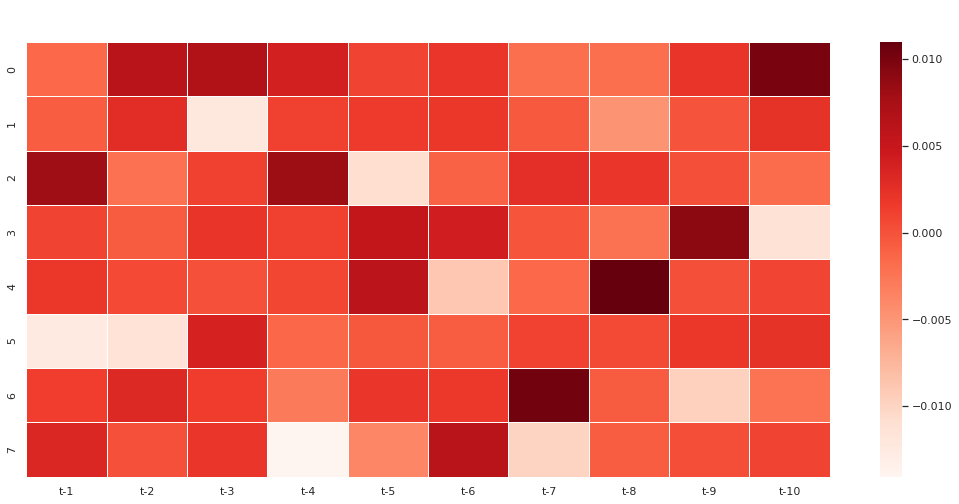

In [29]:
heatmap(summmary.drop(columns = ['counts', 'cluster']))

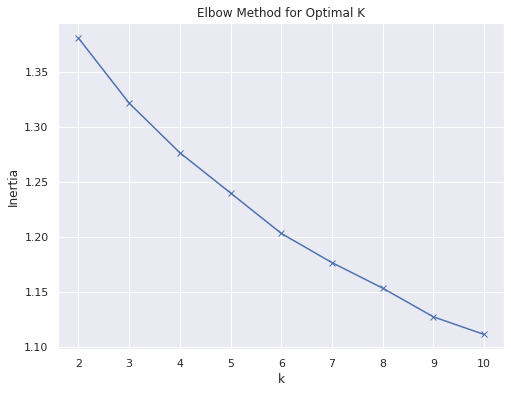

In [30]:
# elbow plot
inertia = []
K = range(2,11,1)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(X)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(8,6))
plt.plot(K,inertia,'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [0]:
X

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
15,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792,-0.021463
16,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545,-0.007792
17,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171,0.006545
18,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993,0.015171
19,-0.000818,-0.004612,0.006279,0.021188,0.013563,-0.012280,0.007734,0.009512,0.000568,0.001993
...,...,...,...,...,...,...,...,...,...,...
1254,-0.010489,-0.016613,0.010702,0.016792,0.007657,-0.001039,0.004267,0.008223,0.002780,0.015579
1255,-0.010131,-0.010489,-0.016613,0.010702,0.016792,0.007657,-0.001039,0.004267,0.008223,0.002780
1256,-0.009856,-0.010131,-0.010489,-0.016613,0.010702,0.016792,0.007657,-0.001039,0.004267,0.008223
1257,-0.042018,-0.009856,-0.010131,-0.010489,-0.016613,0.010702,0.016792,0.007657,-0.001039,0.004267


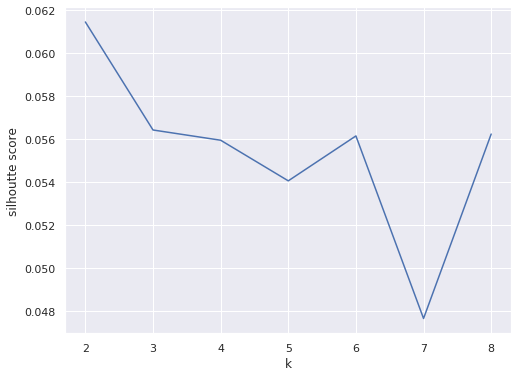

In [31]:
from sklearn.metrics import silhouette_score
# silhoutte score
s_score = []
K = range(2,9,1)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(X)
    y_pred = kmeans.fit_predict(X)
    silhouette_score(X, y_pred)
    s_score.append(silhouette_score(X, y_pred))
plt.figure(figsize=(8,6))
plt.plot(K,s_score)
plt.xlabel('k')
plt.ylabel('silhoutte score')
plt.show()

In [0]:
import pickle

In [27]:
pickled = pickle.dumps(clusters)
pickled

b'\x80\x03cnumpy.core.multiarray\n_reconstruct\nq\x00cnumpy\nndarray\nq\x01K\x00\x85q\x02C\x01bq\x03\x87q\x04Rq\x05(K\x01M\xdd\x04\x85q\x06cnumpy\ndtype\nq\x07X\x02\x00\x00\x00i4q\x08K\x00K\x01\x87q\tRq\n(K\x03X\x01\x00\x00\x00<q\x0bNNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00tq\x0cb\x89Bt\x13\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00